# Abstract #

I'm running this kernel for fun and to learn. My job has nothing to do with statistical learning, so feel free to comment if you see any possible improvement.

I intend to put here both my exploration results and the results of the cross validation of my models. For the latter, as the dataset has many observation, I might run them separately on my personal computer and simply plot the graph in this kernel.
As for the models themselves, I'll run them in separate kernels that I'll linked to this one (by putting the url in comments)

## Exploration Result ##
Here's a takeaway from my exploration:

 - 8 crime categories out of 39 make up to 80% of the crime (said differently, the remaining 30 categories represent less than 1% of crimes each) => I won't try to spend too long predicting this and I'll concentrate on this 8 categories to explore the data (this will free up some space in my graphs)
 - In the long run, the data exhibit some regime changes, especially around 2006 and 2010. While I would not like my model to integrate this directly (I want to put myself in the shoes of a data scientist who makes prediction for the future), I'll try to see if I can make some ex post correction to my model to take this into account
 - Crimes occur at certain hours through the day. The difficulty here comes from the fact that the pattern seems to be the same for each crime category.
 - The same can be said of weekdays, except that it seems that categories are split between weekend crimes (e.g. larcency, non-criminal) and Wednesday crimes (e.g. narcotic, warrants)
 - For an unknown reason, the crime rate seems to be higher during winter and decrease through the year. I expected the contrary and I found no explanation for this phenomenon so far.
 - An analysis of crime spread through districts shows that:
    - Some district are closely associated with certain crimes (e.g. Mission district and prostitution)
    - Unfortunately, larcency/theft and other offenses still represent the largest share of crimes for each district


## Models and Scores ##
- Null model: 3.65 LB
 - Time only, naive Bayes: 3.57 (HUUUUGE improvement ^_^)

# Retrieving Data #

Let's load a bunch of library

In [1]:
%matplotlib inline
#Basic libraries
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import math
#Plots
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
#Format
from datetime import tzinfo, timedelta, datetime
#Models
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import RadiusNeighborsClassifier
from sklearn.neighbors import KNeighborsClassifier

In [2]:
df_train = pd.read_csv("../input/train.csv",index_col=None)
df_train.dtypes

Dates          object
Category       object
Descript       object
DayOfWeek      object
PdDistrict     object
Resolution     object
Address        object
X             float64
Y             float64
dtype: object

What do we have?

 - Category: what is intended to be predicted
 - Description: not so useful for now, but can be later for further analysis (e.g. see crimes that are linked to each other)
 - Dates (in datetime): it could be a good idea to split this in two or more columns (date, time, season and so on) and days of week
 - District: district names
 - Address: 
 - X and Y coordinates: a class to manage this will probably helpful

# Single Variable Analysis #

First, I'll have a look at single variables to see what I have

## Categories ##

The most important things to begin is to get individual categories. The Evaluation sections specifies that the orders for the submission file does not matter.

In [3]:
Crime_Categories = list(df_train.loc[:,"Category"].unique())
print("Number of crime categories: " + str(len(Crime_Categories)))
for crime in Crime_Categories:
    print(crime)

Number of crime categories: 39
WARRANTS
OTHER OFFENSES
LARCENY/THEFT
VEHICLE THEFT
VANDALISM
NON-CRIMINAL
ROBBERY
ASSAULT
WEAPON LAWS
BURGLARY
SUSPICIOUS OCC
DRUNKENNESS
FORGERY/COUNTERFEITING
DRUG/NARCOTIC
STOLEN PROPERTY
SECONDARY CODES
TRESPASS
MISSING PERSON
FRAUD
KIDNAPPING
RUNAWAY
DRIVING UNDER THE INFLUENCE
SEX OFFENSES FORCIBLE
PROSTITUTION
DISORDERLY CONDUCT
ARSON
FAMILY OFFENSES
LIQUOR LAWS
BRIBERY
EMBEZZLEMENT
SUICIDE
LOITERING
SEX OFFENSES NON FORCIBLE
EXTORTION
GAMBLING
BAD CHECKS
TREA
RECOVERED VEHICLE
PORNOGRAPHY/OBSCENE MAT


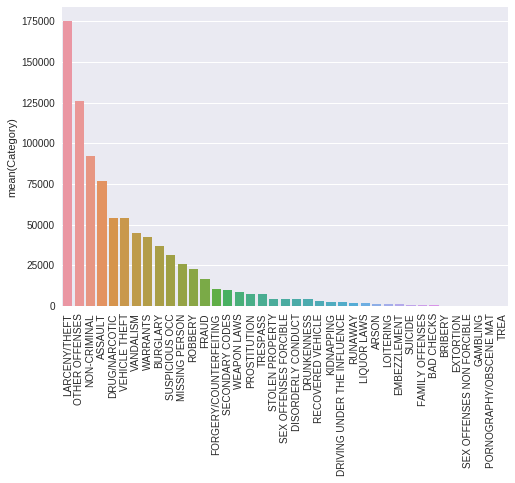

In [4]:
number_of_crimes = df_train.Category.value_counts()

_n_crime_plot = sns.barplot(x=number_of_crimes.index,y=number_of_crimes)
_n_crime_plot.set_xticklabels(number_of_crimes.index,rotation=90)

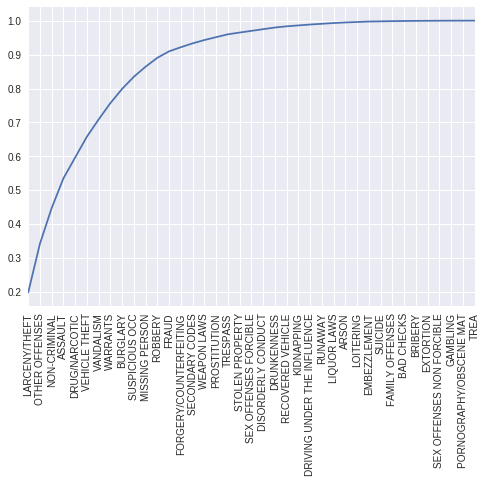

In [5]:
pareto_crime = number_of_crimes / sum(number_of_crimes)
pareto_crime = pareto_crime.cumsum()
_pareto_crime_plot = sns.tsplot(data=pareto_crime)
_pareto_crime_plot.set_xticklabels(pareto_crime.index,rotation=90)
_pareto_crime_plot.set_xticks(np.arange(len(pareto_crime)))
                              

As predicted by our beloved friend Vilfredo, about 20% (exactly 9 out of 39, which is 23%) of the categories account for (nearly exactly) 80% of the crimes.

My take on this: just concentrate on these 9. The remainder 30 categories won't be of any help to get a good score.

In [6]:
Main_Crime_Categories = list(pareto_crime[0:8].index)
print("The following categories :")
print(Main_Crime_Categories)
print("make up to {:.2%} of the crimes".format(pareto_crime[8]))

The following categories :
['LARCENY/THEFT', 'OTHER OFFENSES', 'NON-CRIMINAL', 'ASSAULT', 'DRUG/NARCOTIC', 'VEHICLE THEFT', 'VANDALISM', 'WARRANTS']
make up to 79.92% of the crimes


Concerning the remaining categories, I'll see later what to do with them.

## Dates and Days of Week ##

Let's first check the format used for the days of week and see how many crimes do we have for each of them

In [7]:
df_train.DayOfWeek.value_counts()

Friday       133734
Wednesday    129211
Saturday     126810
Thursday     125038
Tuesday      124965
Monday       121584
Sunday       116707
Name: DayOfWeek, dtype: int64

Not so much to say here: the full names of the days are used and it seems that there are no material differences in term of number of crime for each day.

It doesn't mean that this is not an interesting variable as it may be useful to predict some crimes (I suspect that more DRUG/NARCOTIC crimes are recorded from Thursday pm to Sunday am than during other days).

What about the date format?

In [8]:
df_train.head().Dates

0    2015-05-13 23:53:00
1    2015-05-13 23:53:00
2    2015-05-13 23:33:00
3    2015-05-13 23:30:00
4    2015-05-13 23:30:00
Name: Dates, dtype: object

So basically: YYYY-MM-DD hh:mm:ss
I think it worths to stop here for a moment and to think about the way to split this.

 1. First, I think that the repartition of crime types will likely evolve as the population changes within a given area. Therefore, I intend to use a relative time scale with 0 = 2013-01-01 00:00:00 and +1 for each day
 2. I would like to manually label certain period of the days. Certain crimes are more likely to occur during day time, other at night
 3. A week day / week-end binary variable should be a good idea as well. I'll try to take into account holidays as well
 4. Concerning the hour of the day, I would like to avoid non-linearity: crimes that occur at 11:00 pm are more likely to occur as well at 03:00am than at 5:00pm. To overcome this, I could either start the scale for hours at an arbitrary but better time (e.g. 6:00am) or use a categorical variable.

### Relative Time Scale ###

In [9]:
origin_date = datetime.strptime('2003-01-01 00:00:00','%Y-%m-%d %H:%M:%S')

def delta_origin_date(dt):
    _ = datetime.strptime(dt,'%Y-%m-%d %H:%M:%S') - origin_date
    return(_.days+(_.seconds/86400))

delta_origin_date(df_train.loc[1,"Dates"])

4515.9951388888885

In [10]:
tmp = df_train.loc[:,["Dates","Category"]]
tmp["RelativeDates"]=df_train.Dates.map(delta_origin_date)
tmp.head()

,Dates,Category,RelativeDates
0,2015-05-13 23:53:00,WARRANTS,4515.995139
1,2015-05-13 23:53:00,OTHER OFFENSES,4515.995139
2,2015-05-13 23:33:00,OTHER OFFENSES,4515.981250
3,2015-05-13 23:30:00,LARCENY/THEFT,4515.979167
4,2015-05-13 23:30:00,LARCENY/THEFT,4515.979167


At this stage, it can be interesting to see how the number of crimes per ~ quarter evolved to see if the RelativeDates variable makes sense.
To proceed, I'll cut my variables by buckets of roughly 90 days and plot it as a stacked area plot. This will allow to see at once both the increase/decrease of total crimes and the split of crime categories over time.

In [11]:
tmp["QuarterBucket"]=tmp.RelativeDates.map(lambda d: int(d/90.0))

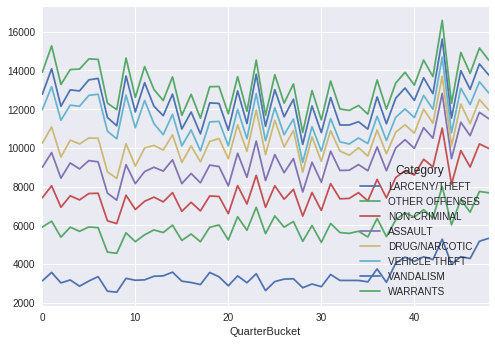

In [12]:
pt = pd.pivot_table(tmp,index="QuarterBucket",columns="Category",aggfunc=len,fill_value=0)
pt = pt["Dates"]
pt[Main_Crime_Categories].iloc[:49,:].cumsum(1).plot()

There's a lot of noise in this graph. I'll take a 3Q-smoothed average of it to make trends easier to see.

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: pd.rolling_mean is deprecated for DataFrame and will be removed in a future version, replace with 
	DataFrame.rolling(window=3,center=False).mean()
  """Entry point for launching an IPython kernel.


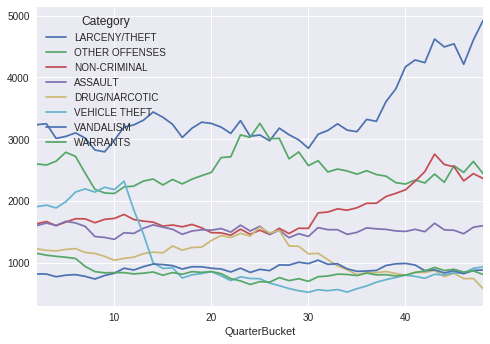

In [13]:
pd.rolling_mean(pt[Main_Crime_Categories],3).iloc[2:49,:].plot()

Some observations at this stage (probably more will come when I'll cross these data with locations):

 - From 2011 onward, the LARCENCY/THEFT categories saw a huge increase
 - The NON-CRIMINAL followed the same trend, bug began slightly before (middle of 2010)
 - DRUG/NARCOTIC decreased roughly starting from the same period
 - The largest drop comes from VEHICLE THEFT in 2006

This clearly indicates that crime categories experienced at least two regime changes, one in 2006, on in 2010. I'd rather like not to use this indicator directly to predict the probability of crime categories, but rather as a correcting factor (this has nothing to do about obtaining a good score, but it's rather about make it as kinda "real" tool for crime prediction)

### Hour of the Day ###

Let's have a look at the hour at which crimes occur through days.

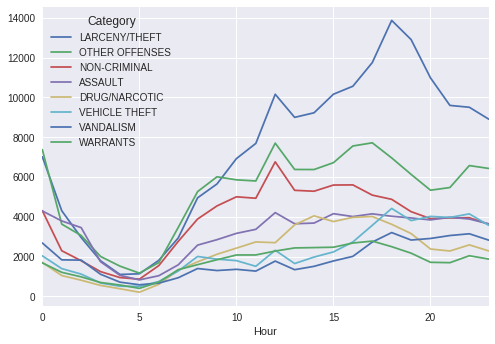

In [14]:
tmp = df_train.loc[:,["Dates","Category"]]

tmp.loc[:,"Hour"] = df_train.Dates.map(lambda d: datetime.strptime(d,'%Y-%m-%d %H:%M:%S').hour)
tmp.describe()

pt = pd.pivot_table(tmp,index="Hour",columns="Category",aggfunc=len,fill_value=0)["Dates"]
pt.loc[:,Main_Crime_Categories].plot()

Well, that does not seem very useful now. All categories follow the same kind of trend: nothing append at 5am and the majority of them occurs around 6pm.
I'll see later if other trends appear when mixed with other variables.

### Weekend / Weekdays ###

Is there any difference between weekdays and weekend?

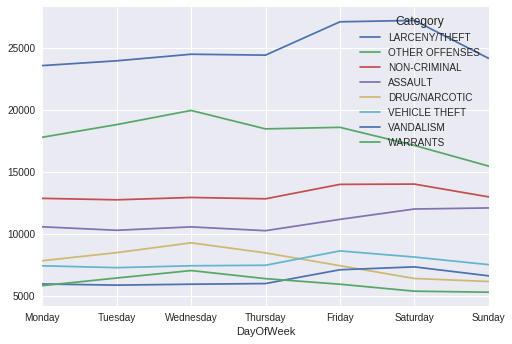

In [15]:
tmp = df_train.loc[:,["DayOfWeek","Category"]]
pt = pd.pivot_table(tmp,index="DayOfWeek",columns="Category",aggfunc=len,fill_value=0)
pt.loc[["Monday","Tuesday","Wednesday","Thursday","Friday","Saturday","Sunday"],
       Main_Crime_Categories].plot()

It does not seem that the difference is significant. However, it is worth noting that the real shift seems to occur in Friday and Monday, not in Saturday and Sunday. We also have some "Wednesday crimes" here. I would visually split the categories this way:
 
- Weekend crimes:
  - LARCENCY/THEFT
  - NON-CRIMINAL
  - VEHICLE THEFT
  - VANDALISM
  - ASSAULT
- Wednesday crimes:
  - OTHER OFFENSES
  - DRUG/NARCOTIC
  - WARRANTS
### Seasons ###

Is there any difference between summer and winter?

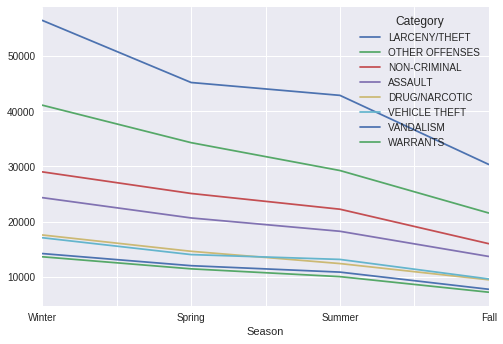

In [16]:
tmp = df_train.loc[:,["Dates","Category"]]

def assign_season(dt):
    _ = datetime.strptime(dt,'%Y-%m-%d %H:%M:%S')
    if _.month >= 11 or _.month <= 2:
        return("Winter")
    elif _.month > 2 and _.month < 6:
        return("Spring")
    elif _.month >= 6 and _.month < 9:
        return("Summer")
    else:
        return("Fall")
    
tmp.loc[:,"Season"] = tmp.Dates.map(assign_season)
pt = pd.pivot_table(tmp,index="Season",columns="Category",aggfunc=len,fill_value=0)["Dates"]
pt.loc[["Winter","Spring","Summer","Fall"],Main_Crime_Categories].plot()

Aggregating by season clearly lack in granularity. Therefore, I'll try with months.

### Months ###

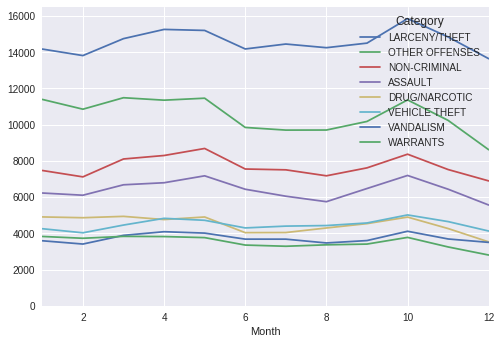

In [17]:
tmp = df_train.loc[:,["Dates","Category"]]
tmp.loc[:,"Month"] = tmp.Dates.map(lambda dt: datetime.strptime(dt,'%Y-%m-%d %H:%M:%S').month)
pt = pd.pivot_table(tmp,index="Month",columns="Category",aggfunc=len,fill_value=0)["Dates"]
pt.loc[:,Main_Crime_Categories].plot(ylim=0)

That's quite unexpected: why do we have such a surge in October? I recall reading that most crimes occurred during summer and I see here that it looks like these data show the contrary.

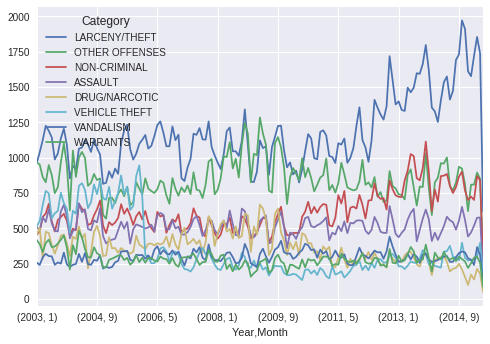

In [18]:
tmp.loc[:,"Year"] = tmp.Dates.map(lambda dt: datetime.strptime(dt,'%Y-%m-%d %H:%M:%S').year)
pt = pd.pivot_table(tmp,index=["Year","Month"],columns="Category",aggfunc=len,fill_value=0)["Dates"]
pt[Main_Crime_Categories].plot()

#Remember to delete this, this is just for a test for FFT
y = pt

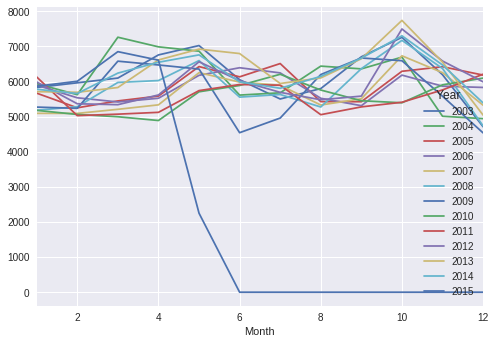

In [19]:
pt = pd.pivot_table(tmp,index="Month",columns="Year",aggfunc=len,fill_value=0)["Dates"]
pt.plot()

At this stage, I'm still a bit puzzled. It seems from the long term disaggregated data that the occurrence of crimes is periodic, while it can hardly be seen on monthly aggregated graph.

I'll try a DFT on the data to see if anything interesting comes up.

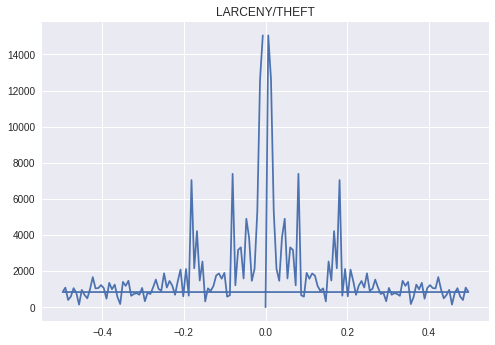

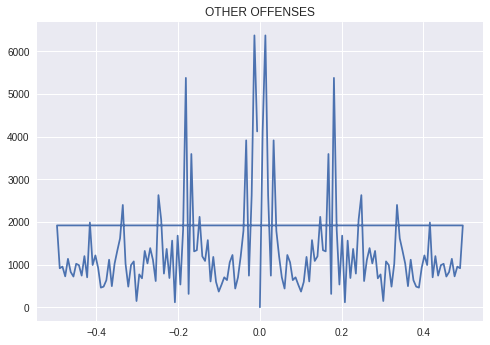

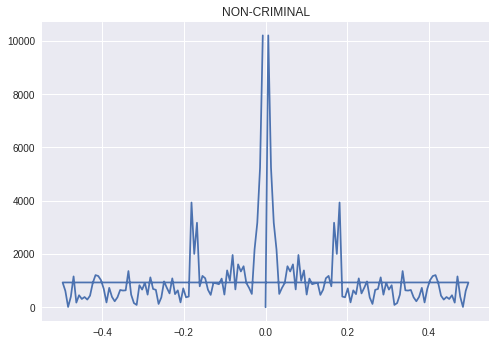

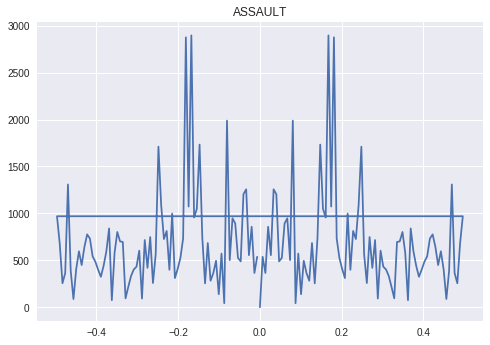

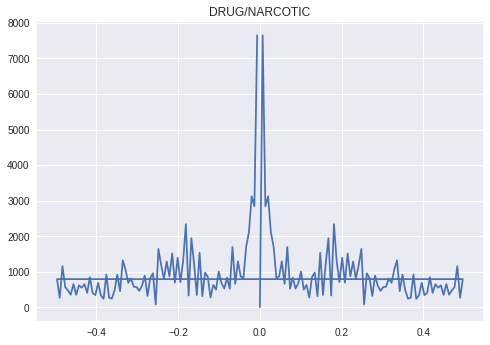

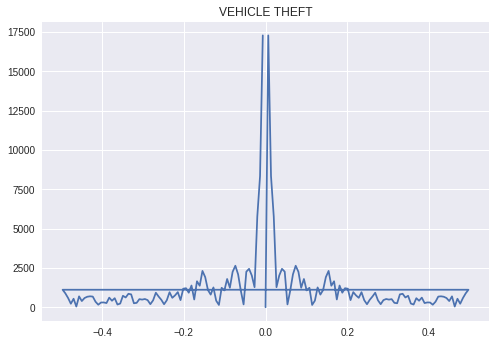

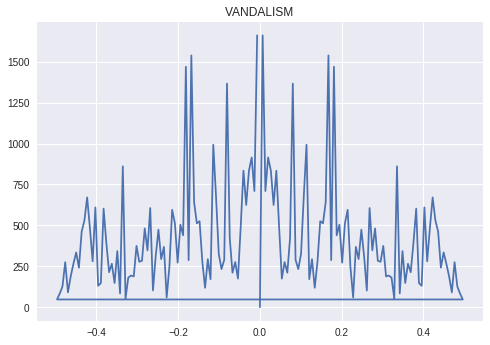

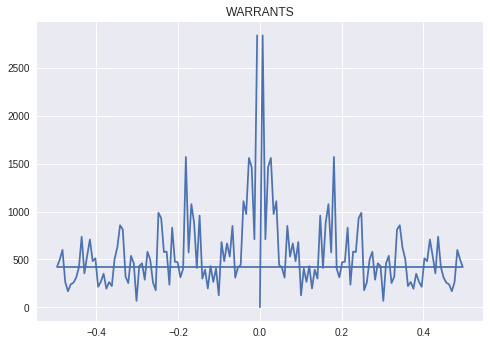

In [20]:
for cat in Main_Crime_Categories:
    spectrum = np.fft.fft(y[cat].iloc[:]-y[cat].iloc[:].mean())
    freq = np.fft.fftfreq(len(spectrum))
    plt.plot(freq, np.absolute(spectrum))
    plt.title(cat)
    plt.show()

All of the spectrum have a spike at around the 0.17 frequency, which corresponds to about 6 months. This is consistent with the number of crimes by month which shows a first high in April, followed by a second one in October.

## Locations ##

Let's have a look to the location of crimes

### District ###

I'll first begin with the districts. I expect this information to be redundant with the coordinates of the crimes, but it will make the exploration easier to begin.

First of all, are there any districts that are more dangerous than others?

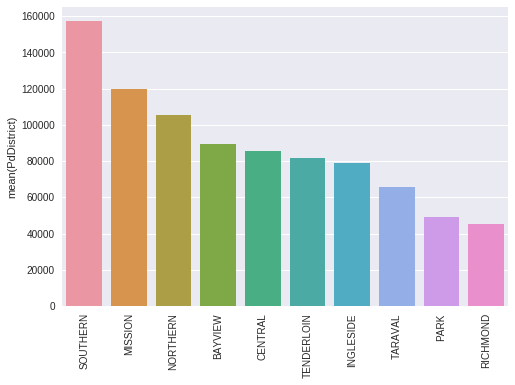

In [21]:
most_dangerous_districts = df_train.PdDistrict.value_counts()
_n_crime_plot = sns.barplot(x=most_dangerous_districts.index,y=most_dangerous_districts)
_n_crime_plot.set_xticklabels(most_dangerous_districts.index,rotation=90)

Clearly, there are differences in the occurrence of crimes through district.

Let us now have a look on how crimes spread through these districts:

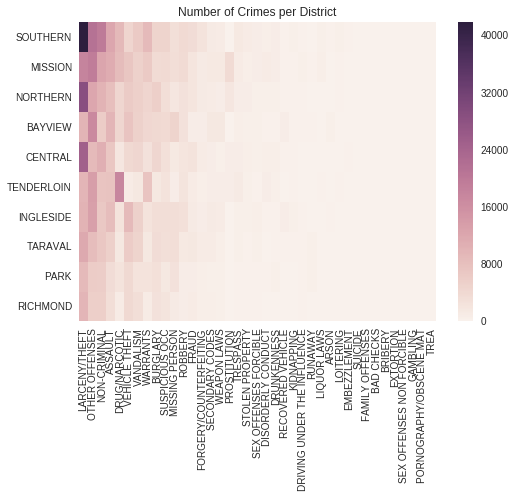

In [22]:
pt = pd.pivot_table(df_train,index="PdDistrict",columns="Category",aggfunc=len,fill_value=0)["Dates"]
_ = pt.loc[most_dangerous_districts.index,number_of_crimes.index]
ax = sns.heatmap(_)
ax.set_title("Number of Crimes per District")

Due to the high number of LARCENCY/THEFT category in the data, this does not really allow to see things more clearly.

An important thing to look at at this stage is to see whether some crimes occur more at certain locations.

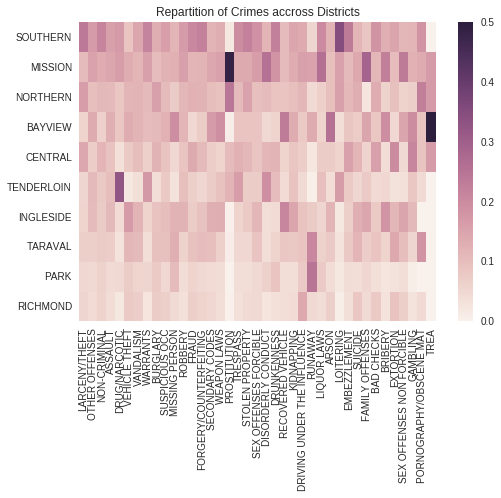

In [23]:
pt = pd.pivot_table(df_train,index="PdDistrict",columns="Category",aggfunc=len,fill_value=0)["Dates"]
pt = pt/pt.sum(axis = 0)
_ = pt.loc[most_dangerous_districts.index,number_of_crimes.index]
ax = sns.heatmap(_)
ax.set_title("Repartition of Crimes accross Districts")

This heatmap deserves a lot of comments:

 - Larcency and theft are roughly equally split through districts, although the Souther, Norther and Central districts concentrate a large part of it
 - The Tenderloin district seems to be the drug sales point
 - Mission district concentrate a large share of prostitution related offenses
 - Bayview concentrate a large share of arson

This graph shows that certain categories of crimes seems to be more frequent in some areas, which is a good starting point. However, the next heatmap reveals that the high number of larcency crimes relative to other categories will complicate the task:

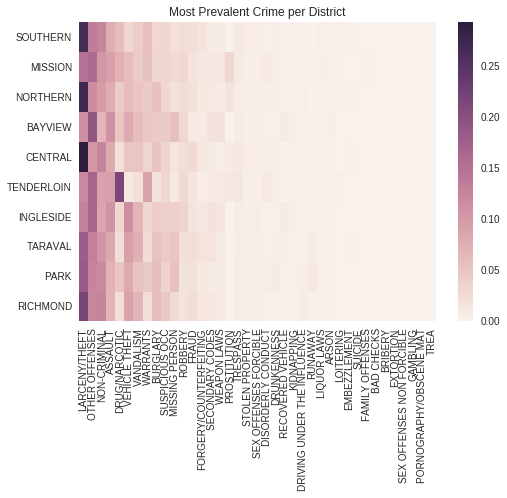

In [24]:
pt = pd.pivot_table(df_train,index="PdDistrict",columns="Category",aggfunc=len,fill_value=0)["Dates"]
pt = pt.div(pt.sum(axis = 1),axis=0)
_ = pt.loc[most_dangerous_districts.index,number_of_crimes.index]
ax = sns.heatmap(_)
ax.set_title("Most Prevalent Crime per District")

Except for the Tenderloin district where the main crime category is related to drugs, all other districts are overwhelmed by LARCENCY/THEFT and OTHER OFFENSES categories.

### Crime Coordinates ###

Now that a first analysis of districts has been done, let's have a look at x,y coordinates. The previous analysis should help us to dig dipper in the data, but for now, let's get the whole train set and see what comes out.

I'll first assign a new value to X and Y coordinates when the value seems strage (i.e. it's a bit far from SF)

In [25]:
def correct_coordinates(district):
    tmp = df_train[df_train["PdDistrict"] == district]
    x_avg = tmp.X.mean()
    y_avg = tmp.Y.mean()
    return([x_avg,y_avg])

index_to_correct = df_train[(df_train["X"] > -121)|(df_train["Y"] > 50)].index

for i in index_to_correct:
    tmp = correct_coordinates(df_train.loc[i,"PdDistrict"])
    x = tmp[0]
    y = tmp[1]
    df_train.loc[i,"X"] = x 
    df_train.loc[i,"Y"] = y

Coordinates box: [[-122.51364206 -122.36493749]
 [  37.70787902   37.81997549]]
Barycenter: [-122.42276320915532, 37.76703518816732]


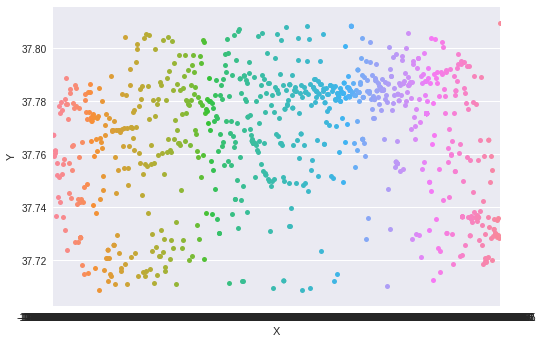

In [26]:
xy_box = np.zeros([2,2])

xy_box[0,0] = df_train["X"].min()
xy_box[0,1] = df_train["X"].max()
xy_box[1,0] = df_train["Y"].min()
xy_box[1,1] = df_train["Y"].max()


barycenter = [df_train["X"].sum()/len(df_train["X"]),df_train["Y"].sum()/len(df_train["Y"])]
print("Coordinates box: {}".format(xy_box))
print("Barycenter: {}".format(barycenter))

df_plot_coordinates = df_train[["X","Y"]].sample(frac=0.001)
sns.stripplot(df_plot_coordinates["X"],df_plot_coordinates["Y"])

We have far too many points to plot, so I'll try a different approach. Some categories seem to be located in certain district, so I'll try to see I can refine this analysis to find hotspots for these crimes (and potentially compute the distance between these hotspots and crime locations)

/opt/conda/lib/python3.6/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


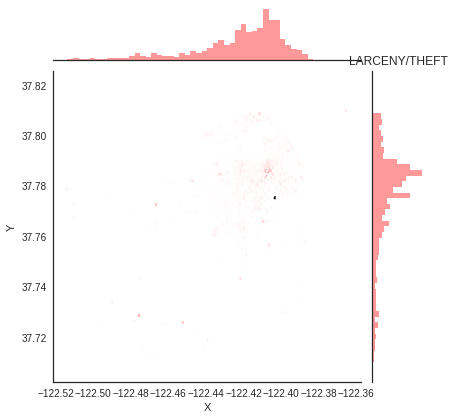

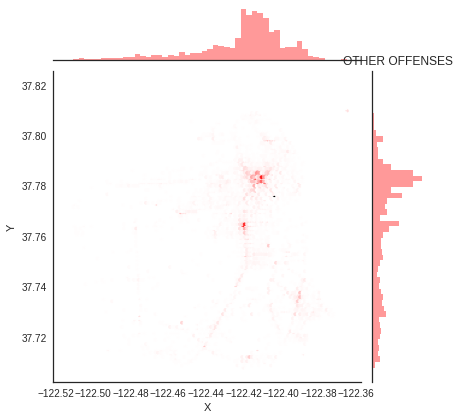

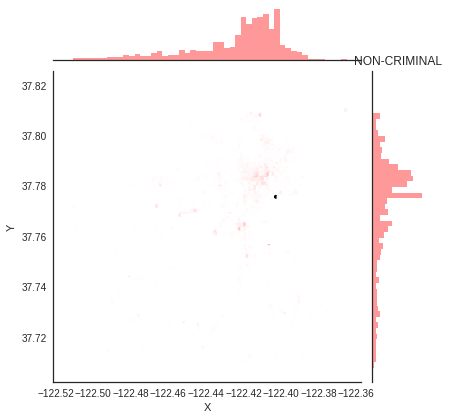

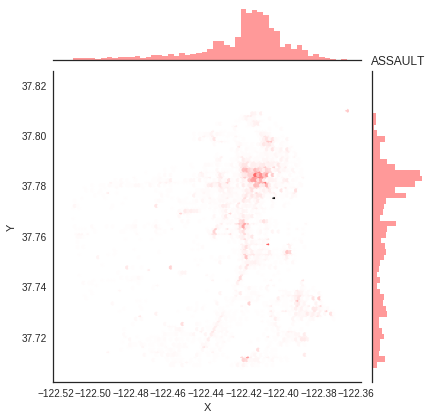

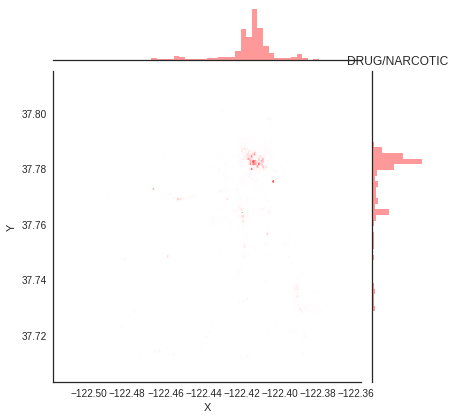

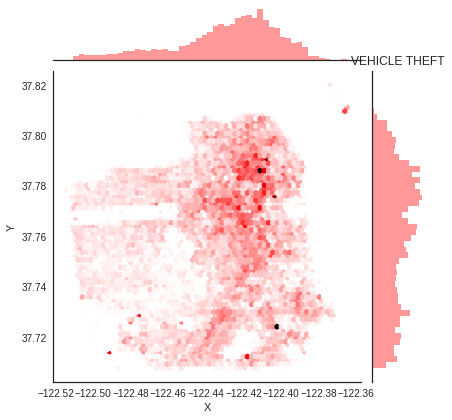

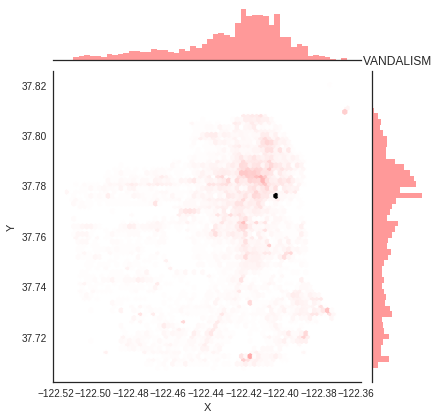

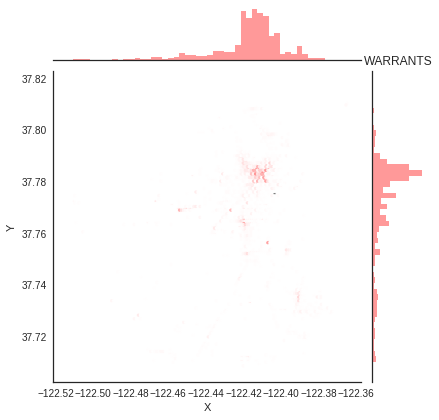

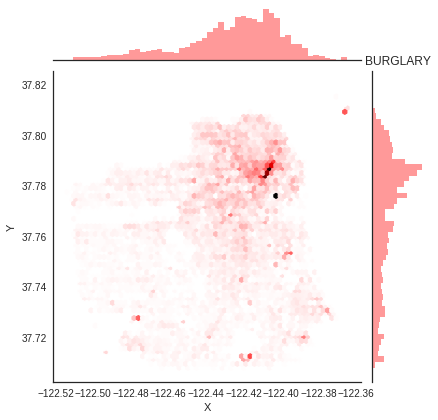

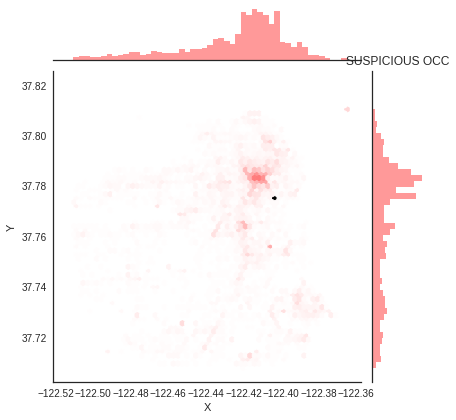

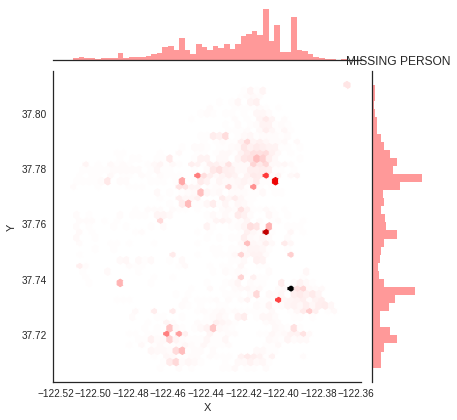

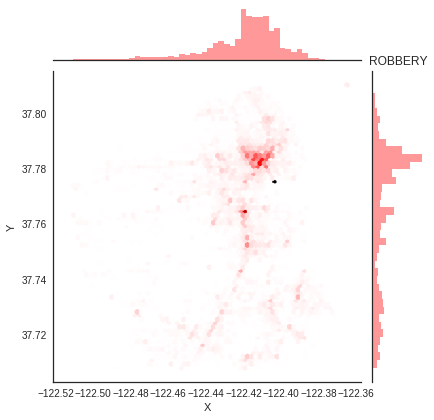

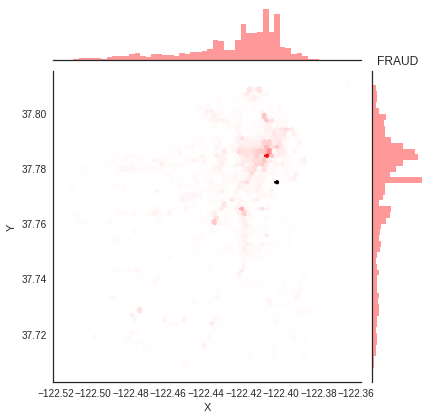

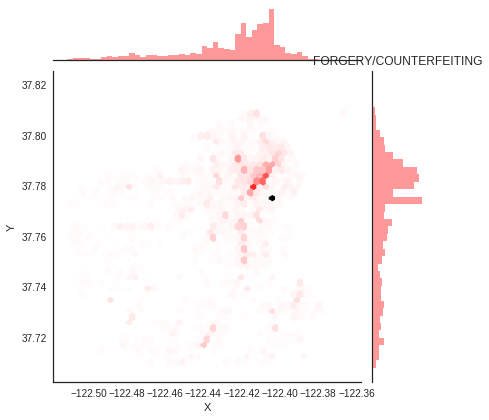

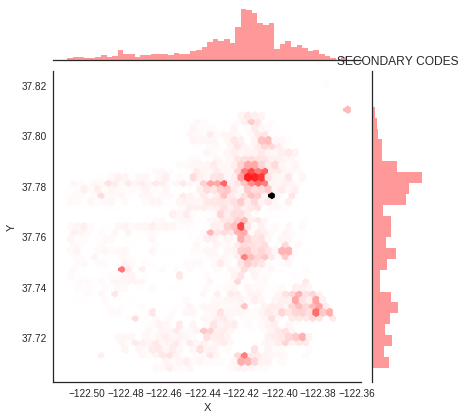

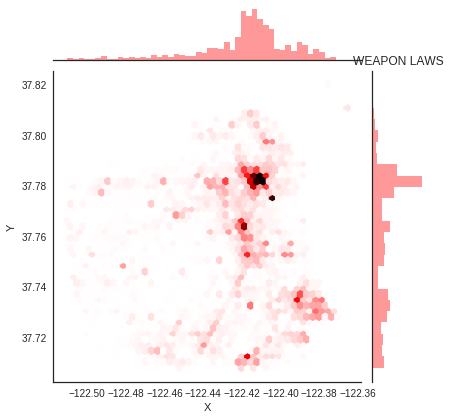

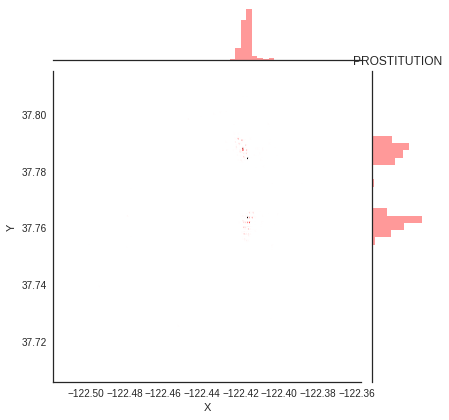

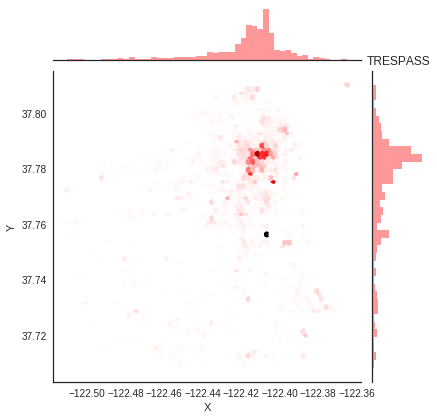

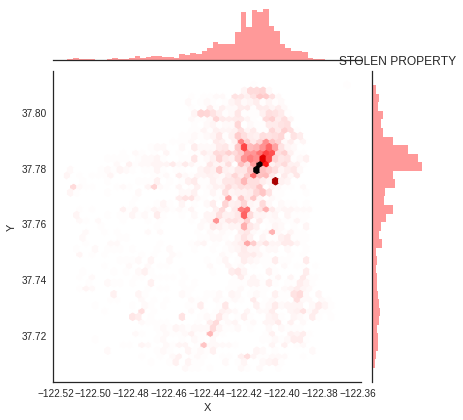

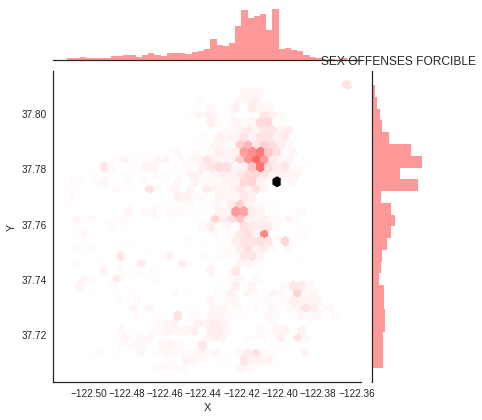

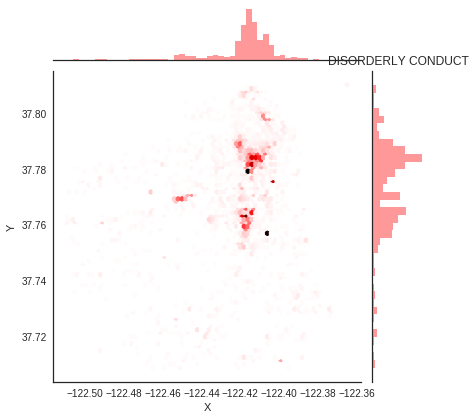

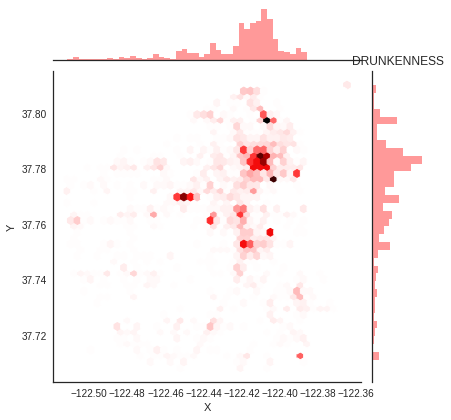

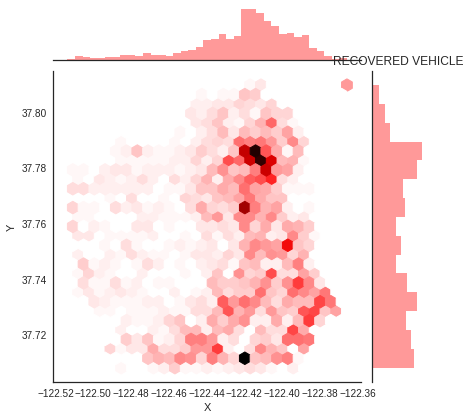

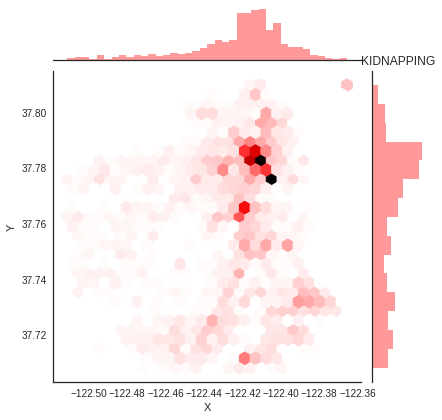

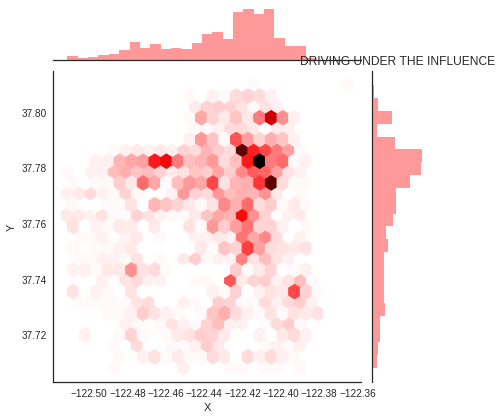

In [27]:
for c in pareto_crime.index[:25]:
    df_tmp = df_train.loc[df_train.Category == c,["X","Y"]]
    with sns.axes_style("white"):
        sns.jointplot(x=df_tmp["X"] , y=df_tmp["Y"], stat_func = None,kind="hex", color="r");
        sns.plt.title(c)

(NB: after a first try, I plotted only the 25 first categories. The remainder did not brought many information)



# Training Models #

Before to go any further, let's load the test set.

In [28]:
df_test = pd.read_csv("../input/test.csv",index_col=None)
df_test.head()

,Id,Dates,DayOfWeek,PdDistrict,Address,X,Y
0,0,2015-05-10 23:59:00,Sunday,BAYVIEW,2000 Block of THOMAS AV,-122.399588,37.735051
1,1,2015-05-10 23:51:00,Sunday,BAYVIEW,3RD ST / REVERE AV,-122.391523,37.732432
2,2,2015-05-10 23:50:00,Sunday,NORTHERN,2000 Block of GOUGH ST,-122.426002,37.792212
3,3,2015-05-10 23:45:00,Sunday,INGLESIDE,4700 Block of MISSION ST,-122.437394,37.721412
4,4,2015-05-10 23:45:00,Sunday,INGLESIDE,4700 Block of MISSION ST,-122.437394,37.721412




## Null Model: Average ##

Since my job is in now way related to Kaggle, it's hard for me to have a clear self-evaluation of how well I'm doing. So I'll make a first submission with the average of each crime and consider it as a starting point to see if I'm improving my model compared to it.

In [29]:
model_null = df_test[["Id"]]
for crime in Crime_Categories:
    model_null[crime] = number_of_crimes[crime]/sum(number_of_crimes)
model_null.head()
#The output file seems to be to heavy
#model_null.to_csv("model_null.csv")

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,Id,WARRANTS,OTHER OFFENSES,LARCENY/THEFT,VEHICLE THEFT,VANDALISM,NON-CRIMINAL,ROBBERY,ASSAULT,WEAPON LAWS,...,EMBEZZLEMENT,SUICIDE,LOITERING,SEX OFFENSES NON FORCIBLE,EXTORTION,GAMBLING,BAD CHECKS,TREA,RECOVERED VEHICLE,PORNOGRAPHY/OBSCENE MAT
0,0,0.048077,0.143707,0.199192,0.061251,0.050937,0.105124,0.026194,0.087553,0.009743,...,0.001328,0.000579,0.001395,0.000169,0.000292,0.000166,0.000462,0.000007,0.003574,0.000025
1,1,0.048077,0.143707,0.199192,0.061251,0.050937,0.105124,0.026194,0.087553,0.009743,...,0.001328,0.000579,0.001395,0.000169,0.000292,0.000166,0.000462,0.000007,0.003574,0.000025
2,2,0.048077,0.143707,0.199192,0.061251,0.050937,0.105124,0.026194,0.087553,0.009743,...,0.001328,0.000579,0.001395,0.000169,0.000292,0.000166,0.000462,0.000007,0.003574,0.000025
3,3,0.048077,0.143707,0.199192,0.061251,0.050937,0.105124,0.026194,0.087553,0.009743,...,0.001328,0.000579,0.001395,0.000169,0.000292,0.000166,0.000462,0.000007,0.003574,0.000025
4,4,0.048077,0.143707,0.199192,0.061251,0.050937,0.105124,0.026194,0.087553,0.009743,...,0.001328,0.000579,0.001395,0.000169,0.000292,0.000166,0.000462,0.000007,0.003574,0.000025


## Time-Only Model ##
The first real model that I'll try will only use the inputs from the time of the crimes (including days of the week, hours and months). Because of the constraint I imposed on myself not to benefit from a look-ahead bias, I'll train 11 different models, using only data from the previous years (except for 2013 for which I have no other choices but to use the data from 2013. This said, the number 11 comes from 13 years - 2003 - 2015)

In [30]:
def is_weekend(d):
    if d in ["Friday","Saturday","Sunday"]:
        return(1)
    else:
        return(0)
    
def get_hour(d):
    h = datetime.strptime(d,'%Y-%m-%d %H:%M:%S').hour
    s = datetime.strptime(d,'%Y-%m-%d %H:%M:%S').second
    return((h+s/60.0)/24.0)
    

#df_train_time_only = df_train
#df_train_time_only["Year"] = df_train_time_only.Dates.map(lambda dt: datetime.strptime(dt,'%Y-%m-%d %H:%M:%S').year)
#df_train_time_only["Month"] = df_train_time_only.Dates.map(lambda dt: datetime.strptime(dt,'%Y-%m-%d %H:%M:%S').month/12.0)
#df_train_time_only["Hour"] = df_train_time_only.Dates.map(get_hour)
#df_train_time_only["IsWeekend"] = df_train_time_only.DayOfWeek.map(is_weekend)
#df_train_time_only.head()

In [31]:
def make_as_OTHER(crime):
    if crime in Main_Crime_Categories:
        return(crime)
    else:
        return("OTHER_MANUAL")

#df_tmp = df_train_time_only#[df_train_time_only['Year'].isin([2008,2009,2010,2011,2012,2013,2014])]
#df_tmp["Category"] = df_tmp.Category.map(make_as_OTHER)



#df_x = df_tmp[["Month","IsWeekend","Hour"]]
#df_y = df_tmp["Category"]

#scores = []
#for i in range(5):
#    knn = KNeighborsClassifier(n_neighbors = i + 2)
#    scores.append(cross_val_score(knn,df_x,df_y,cv=2))